In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# without_formal_contract

In [2]:
importance_df_wfc = pd.read_csv('wfc_importance_shap_MLP_100test.csv')
importance_df_wfc = importance_df_wfc.drop(columns=['Impact'])
importance_df_wfc.columns.values[1] = 'MLP'

wfc_importance_shap_CNN_100test = pd.read_csv('wfc_importance_shap_CNN_100test.csv')
wfc_importance_shap_TabNet_100test = pd.read_csv('wfc_importance_shap_TabNet_100test.csv')
wfc_importance_shap_RF_100test = pd.read_csv('wfc_importance_shap_RF_100test.csv')

# Add the second column to importance_df_wfc
importance_df_wfc['CNN'] = wfc_importance_shap_CNN_100test.iloc[:, 1]
importance_df_wfc['TabNet'] = wfc_importance_shap_TabNet_100test.iloc[:, 1]
importance_df_wfc['RF'] = wfc_importance_shap_RF_100test.iloc[:, 1]


In [3]:
importance_df_wfc

,Feature,MLP,CNN,TabNet,RF
0,age,-0.001945,0.001318,0.005985,-0.003261
1,Belgium,0.004701,0.000277,0.000133,-0.000114
2,Denmark,0.000358,0.002065,-0.002156,-0.000033
3,Germany,0.000770,-0.000476,-0.003218,0.000015
4,Greece,0.001281,0.001197,0.001772,-0.000003
...,...,...,...,...,...
121,corruption_Perceptions_Index,-0.001377,0.001134,-0.000924,0.000035
122,confidence_in_EU_institutions,-0.000714,0.000846,-0.002489,-0.000140
123,official_development_assistance,-0.000113,0.000473,-0.000106,0.000043
124,share_of_environmental_taxes,-0.000876,-0.000717,0.003969,-0.000085


In [4]:
importance_df_wfc_fara_tari= importance_df_wfc.drop(importance_df_wfc.index[1:30])   #cut out countries
importance_df_wfc_fara_tari

,Feature,MLP,CNN,TabNet,RF
0,age,-0.001945,0.001318,0.005985,-0.003261
30,life_satisfaction,-0.000195,-0.008595,-0.002021,0.000123
31,interested_in_national_politics,0.000499,-0.002070,-0.002759,-0.000030
32,interested_in_european_politics,0.000577,0.000371,-0.001543,0.000091
33,interested_in_local_politics,0.000247,0.000351,-0.006125,-0.000031
...,...,...,...,...,...
121,corruption_Perceptions_Index,-0.001377,0.001134,-0.000924,0.000035
122,confidence_in_EU_institutions,-0.000714,0.000846,-0.002489,-0.000140
123,official_development_assistance,-0.000113,0.000473,-0.000106,0.000043
124,share_of_environmental_taxes,-0.000876,-0.000717,0.003969,-0.000085


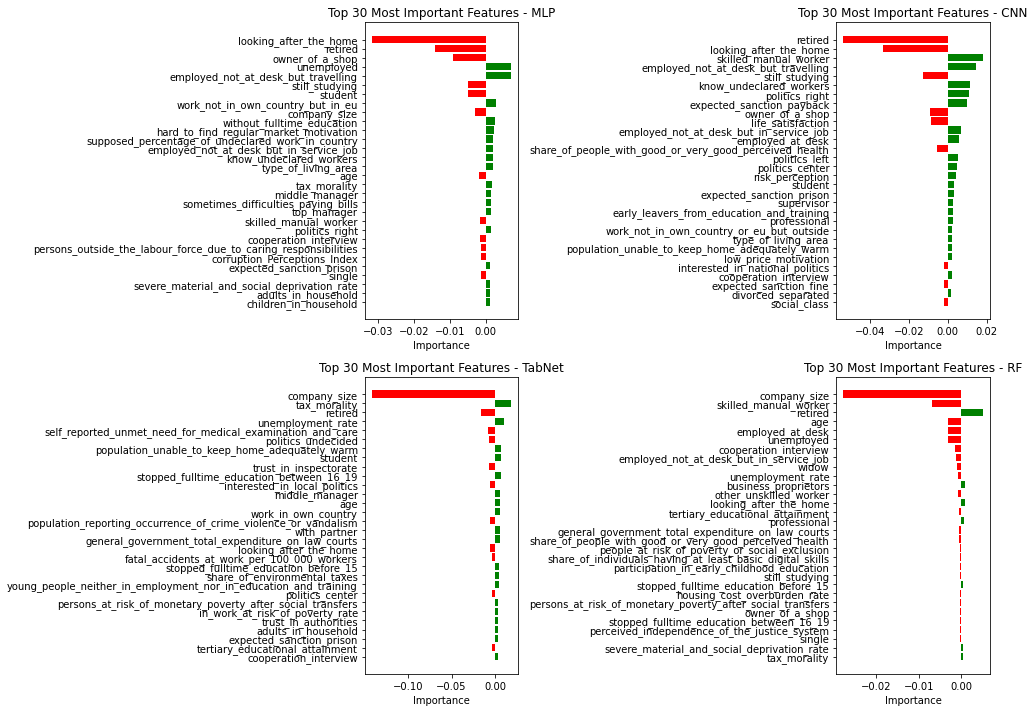

In [8]:
import matplotlib.pyplot as plt

# Exclude the 'Feature' column
important_features_df = importance_df_wfc_fara_tari.set_index('Feature')

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Iterate over each column and plot horizontal bar plot
for i, ax in enumerate(axes.flat):
    col_name = important_features_df.columns[i]
    # Get the top 30 most important features for the current column
    top_features = important_features_df.reindex(important_features_df[col_name].abs().nlargest(30).index)
    # Plot the bar plot
    ax.barh(top_features.index, top_features[col_name], color=top_features[col_name].apply(lambda x: 'green' if x > 0 else 'red'))
    ax.set_xlabel('Importance')
    ax.set_title(f'Top 30 Most Important Features - {col_name}')
    ax.invert_yaxis()  # Invert y-axis to show the most important features at the top

plt.tight_layout()
plt.show()



###  mann witney

In [51]:
import pandas as pd

wfc_rankings = pd.DataFrame(importance_df_wfc['Feature'])

# Iterate over the columns (except the 'Feature' column)
for col in importance_df_wfc.columns[1:]:
    # Get values of each column
    abs_col = importance_df_wfc[col].abs()
    # Rank the values, with method='min' to assign the same rank to ties as per your requirement
    rank = abs_col.rank(method='min', ascending=False)
    # Add the rank as a new column
    wfc_rankings[col+"_Rank"] = rank.astype(int)

# Print the resulting DataFrame
print(wfc_rankings)



                             Feature  MLP_Rank  CNN_Rank  TabNet_Rank  RF_Rank
0                                age        20        53           13        4
1                            Belgium         9       111          109       58
2                            Denmark        88        32           43       96
3                            Germany        55        90           34      113
4                             Greece        34        59           53      123
..                               ...       ...       ...          ...      ...
121     corruption_Perceptions_Index        32        65           73       95
122    confidence_in_EU_institutions        57        76           38       52
123  official_development_assistance       117        92          112       89
124     share_of_environmental_taxes        53        82           23       75
125    general_government_gross_debt       106        49           55       41

[126 rows x 5 columns]


In [52]:
from itertools import combinations
import pandas as pd
from scipy.stats import mannwhitneyu

model_columns = ['MLP_Rank', 'CNN_Rank', 'TabNet_Rank', 'RF_Rank']
results = []

# Iterate over all combinations of model columns
for model1, model2 in combinations(model_columns, 2):
    
    # Perform the Mann-Whitney U test
    # H0: there is no difference between the distributions of the two groups being compared.
    statistic, p_value = mannwhitneyu(wfc_rankings[model1], wfc_rankings[model2])
    
    # Check the significance
    if p_value < 0.05:
        conclusion = "Significant difference"
    else:
        conclusion = "No significant difference"
    
    # Add the results to the list
    results.append({
        'Model 1': model1,
        'Model 2': model2,
        'Mann-Whitney U Statistic': statistic,
        'p-value': p_value,
        'Conclusion': conclusion
    })

# Convert the list of results to a DataFrame
results_df = pd.concat([pd.DataFrame([r]) for r in results], ignore_index=True)
results_df


,Model 1,Model 2,Mann-Whitney U Statistic,p-value,Conclusion
0,MLP_Rank,CNN_Rank,7939.0,0.999310,No significant difference
1,MLP_Rank,TabNet_Rank,8004.0,0.909853,No significant difference
2,MLP_Rank,RF_Rank,7938.0,1.000000,No significant difference
3,CNN_Rank,TabNet_Rank,8004.0,0.909853,No significant difference
4,CNN_Rank,RF_Rank,7937.0,0.999310,No significant difference
5,TabNet_Rank,RF_Rank,7872.0,0.909853,No significant difference


# envelope_wage

In [9]:
importance_df_ew = pd.read_csv('ew_importance_shap_MLP_100test.csv')
importance_df_ew = importance_df_ew.drop(columns=['Impact'])
importance_df_ew.columns.values[1] = 'MLP'

ew_importance_shap_CNN_100test = pd.read_csv('ew_importance_shap_CNN_100test.csv')
ew_importance_shap_TabNet_100test = pd.read_csv('ew_importance_shap_TabNet_100test.csv')
ew_importance_shap_RF_100test = pd.read_csv('ew_importance_shap_RF_100test.csv')

# Add the second column to importance_df_wfc
importance_df_ew['CNN'] = ew_importance_shap_CNN_100test.iloc[:, 1]
importance_df_ew['TabNet'] = ew_importance_shap_TabNet_100test.iloc[:, 1]
importance_df_ew['RF'] = ew_importance_shap_RF_100test.iloc[:, 1]

In [10]:
importance_df_ew

,Feature,MLP,CNN,TabNet,RF
0,age,-0.000165,0.002079,-0.002996,0.000015
1,Belgium,0.004307,-0.002598,-0.004748,-0.000238
2,Denmark,-0.002048,0.001102,-0.003568,-0.000023
3,Germany,0.004475,0.001085,-0.000105,-0.000050
4,Greece,-0.000132,0.000285,0.004311,0.000003
...,...,...,...,...,...
121,corruption_Perceptions_Index,-0.000281,0.001271,-0.003820,0.000424
122,confidence_in_EU_institutions,0.000996,0.002464,0.002788,0.000324
123,official_development_assistance,-0.001961,0.000200,0.000429,0.001424
124,share_of_environmental_taxes,0.001990,0.000738,0.007921,-0.000441


In [11]:
importance_df_ew_fara_tari= importance_df_ew.drop(importance_df_ew.index[1:30])   #cut out countries
importance_df_ew_fara_tari

,Feature,MLP,CNN,TabNet,RF
0,age,-0.000165,0.002079,-0.002996,0.000015
30,life_satisfaction,0.000281,0.004147,0.003640,0.000180
31,interested_in_national_politics,-0.000428,0.002347,-0.004448,0.000286
32,interested_in_european_politics,0.000626,0.003305,0.013904,0.000135
33,interested_in_local_politics,0.001339,0.002541,0.007094,0.000174
...,...,...,...,...,...
121,corruption_Perceptions_Index,-0.000281,0.001271,-0.003820,0.000424
122,confidence_in_EU_institutions,0.000996,0.002464,0.002788,0.000324
123,official_development_assistance,-0.001961,0.000200,0.000429,0.001424
124,share_of_environmental_taxes,0.001990,0.000738,0.007921,-0.000441


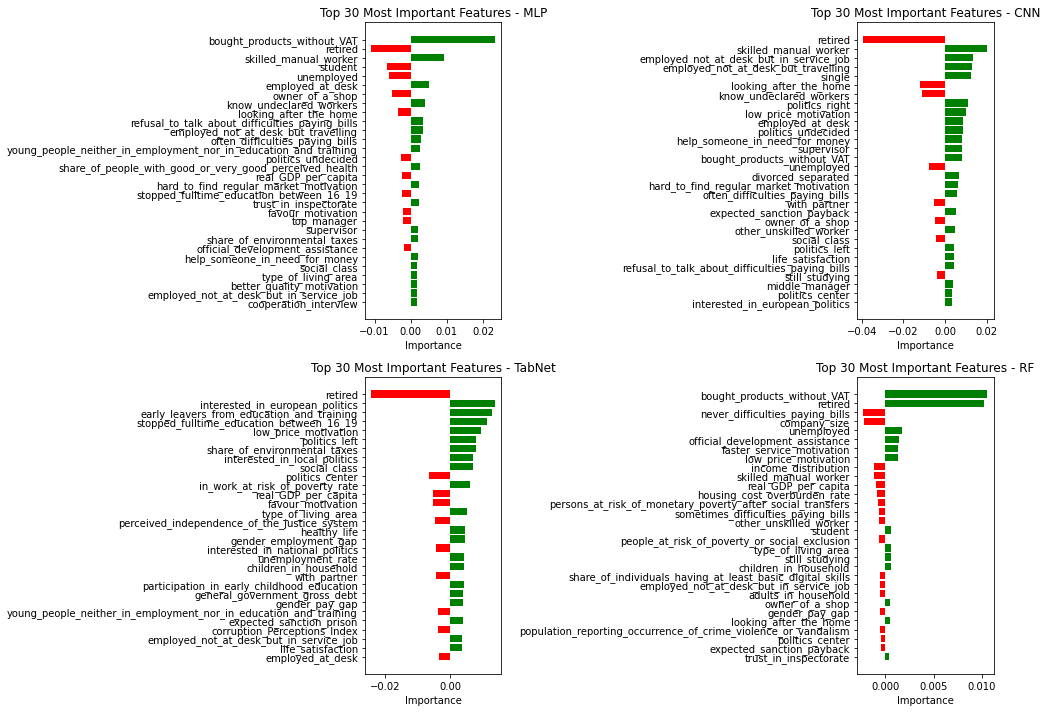

In [12]:
import matplotlib.pyplot as plt

# Exclude the 'Feature' column
important_features_df = importance_df_ew_fara_tari.set_index('Feature')

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Iterate over each column and plot horizontal bar plot
for i, ax in enumerate(axes.flat):
    col_name = important_features_df.columns[i]
    # Get the top 30 most important features for the current column
    top_features = important_features_df.reindex(important_features_df[col_name].abs().nlargest(30).index)
    # Plot the bar plot
    ax.barh(top_features.index, top_features[col_name], color=top_features[col_name].apply(lambda x: 'green' if x > 0 else 'red'))
    ax.set_xlabel('Importance')
    ax.set_title(f'Top 30 Most Important Features - {col_name}')
    ax.invert_yaxis()  # Invert y-axis to show the most important features at the top

plt.tight_layout()
plt.show()


###  mann witney

In [49]:
import pandas as pd

ew_rankings = pd.DataFrame(importance_df_ew['Feature'])

# Iterate over the columns (except the 'Feature' column)
for col in importance_df_ew.columns[1:]:
    # Get  values of each column
    abs_col = importance_df_ew[col].abs()
    # Rank values, with method='min' to assign the same rank to ties as per your requirement
    rank = abs_col.rank(method='min', ascending=False)
    # Add the rank as a new column
    ew_rankings[col+"_Rank"] = rank.astype(int)

# Print the resulting DataFrame
print(ew_rankings)


                             Feature  MLP_Rank  CNN_Rank  TabNet_Rank  RF_Rank
0                                age       111        52           47      110
1                            Belgium        11        42           19       47
2                            Denmark        28        75           38      100
3                            Germany         9        76          113       89
4                             Greece       115       109           28      125
..                               ...       ...       ...          ...      ...
121     corruption_Perceptions_Index       102        69           35       34
122    confidence_in_EU_institutions        67        46           50       40
123  official_development_assistance        32       111          101        6
124     share_of_environmental_taxes        31        85            8       31
125    general_government_gross_debt        42       115           31       52

[126 rows x 5 columns]


In [50]:
from itertools import combinations
import pandas as pd
from scipy.stats import mannwhitneyu

model_columns = ['MLP_Rank', 'CNN_Rank', 'TabNet_Rank', 'RF_Rank']
results = []

# Iterate over all combinations of model columns
for model1, model2 in combinations(model_columns, 2):
    
    # Perform the Mann-Whitney U test
    # H0: there is no difference between the distributions of the two groups being compared.
    statistic, p_value = mannwhitneyu(ew_rankings[model1], ew_rankings[model2])
    
    # Check the significance
    if p_value < 0.05:
        conclusion = "Significant difference"
    else:
        conclusion = "No significant difference"
    
    # Add the results to the list
    results.append({
        'Model 1': model1,
        'Model 2': model2,
        'Mann-Whitney U Statistic': statistic,
        'p-value': p_value,
        'Conclusion': conclusion
    })

# Convert the list of results to a DataFrame
results_df = pd.concat([pd.DataFrame([r]) for r in results], ignore_index=True)
results_df


,Model 1,Model 2,Mann-Whitney U Statistic,p-value,Conclusion
0,MLP_Rank,CNN_Rank,7938.0,1.000000,No significant difference
1,MLP_Rank,TabNet_Rank,8016.0,0.893426,No significant difference
2,MLP_Rank,RF_Rank,7938.0,1.000000,No significant difference
3,CNN_Rank,TabNet_Rank,8016.0,0.893426,No significant difference
4,CNN_Rank,RF_Rank,7938.0,1.000000,No significant difference
5,TabNet_Rank,RF_Rank,7860.0,0.893426,No significant difference


# dep_self_empl

In [13]:
importance_df_dep_self_empl = pd.read_csv('dep_self_empl_importance_shap_MLP_train.csv')
importance_df_dep_self_empl = importance_df_dep_self_empl.drop(columns=['Impact'])
importance_df_dep_self_empl.columns.values[1] = 'MLP'

dep_self_empl_importance_shap_CNN_100test = pd.read_csv('dep_self_empl_importance_shap_CNN_train.csv')
#dep_self_empl_importance_shap_TabNet_100test = pd.read_csv('dep_self_empl_importance_shap_TabNet_100test.csv')
dep_self_empl_importance_shap_RF_100test = pd.read_csv('dep_self_empl_importance_shap_RF_train.csv')

# Add the second column to importance_df_wfc
importance_df_dep_self_empl['CNN'] = dep_self_empl_importance_shap_CNN_100test.iloc[:, 1]
#importance_df_dep_self_empl['TabNet'] = dep_self_empl_importance_shap_TabNet_100test.iloc[:, 1]
importance_df_dep_self_empl['RF'] = dep_self_empl_importance_shap_RF_100test.iloc[:, 1]

In [14]:
importance_df_dep_self_empl

,Feature,MLP,CNN,RF
0,age,0.000106,-0.000080,0.000853
1,Belgium,-0.000151,0.000192,0.000040
2,Denmark,0.000298,-0.001228,0.000000
3,Germany,0.000445,-0.000478,-0.000031
4,Greece,-0.000029,0.000372,0.000096
...,...,...,...,...
121,corruption_Perceptions_Index,0.000260,-0.000244,-0.000905
122,confidence_in_EU_institutions,-0.000093,-0.000206,0.000344
123,official_development_assistance,-0.000290,0.000113,0.000879
124,share_of_environmental_taxes,-0.000226,0.000181,-0.000943


In [15]:
importance_df_dep_self_empl_fara_tari= importance_df_dep_self_empl.drop(importance_df_dep_self_empl.index[1:30])   #cut out countries
importance_df_dep_self_empl_fara_tari

,Feature,MLP,CNN,RF
0,age,0.000106,-0.000080,0.000853
30,life_satisfaction,0.000029,0.001271,0.000114
31,interested_in_national_politics,-0.000057,0.001649,-0.000145
32,interested_in_european_politics,0.000532,0.000850,-0.000233
33,interested_in_local_politics,0.000013,0.001636,-0.000205
...,...,...,...,...
121,corruption_Perceptions_Index,0.000260,-0.000244,-0.000905
122,confidence_in_EU_institutions,-0.000093,-0.000206,0.000344
123,official_development_assistance,-0.000290,0.000113,0.000879
124,share_of_environmental_taxes,-0.000226,0.000181,-0.000943


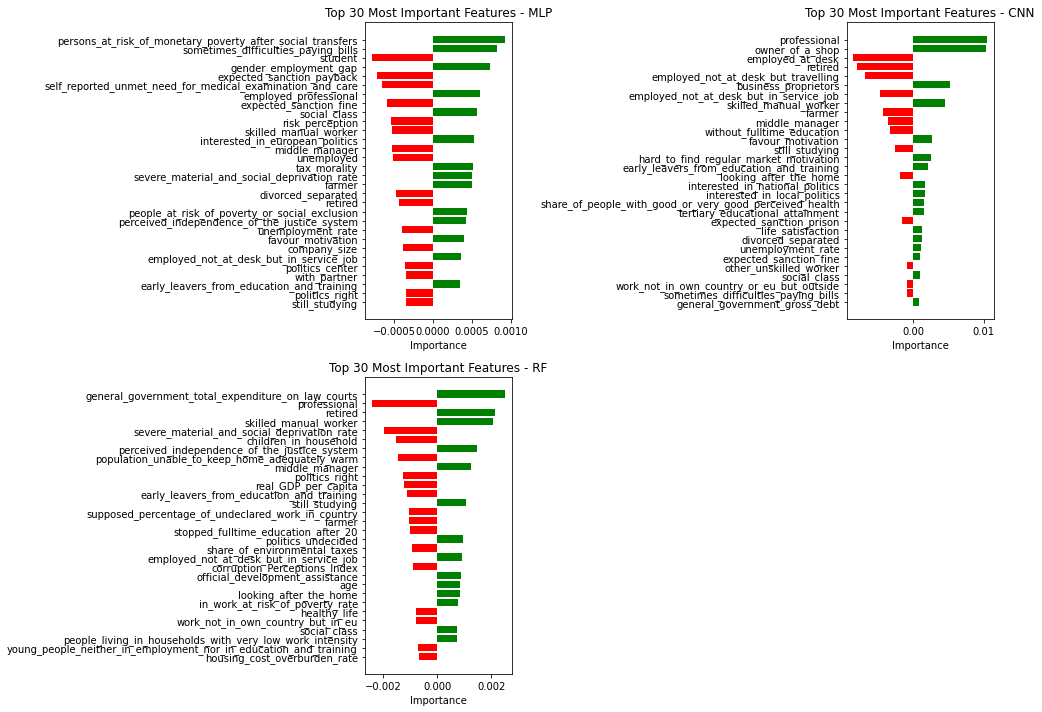

In [20]:
import matplotlib.pyplot as plt

# Exclude the 'Feature' column
important_features_df = importance_df_dep_self_empl_fara_tari.set_index('Feature')

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Iterate over each column and plot horizontal bar plot
for i, ax in enumerate(axes.flat):
    if i < 3:  # Adjusting for the last subplot to be empty
        col_name = important_features_df.columns[i]
        # Get the top 30 most important features for the current column
        top_features = important_features_df.reindex(important_features_df[col_name].abs().nlargest(30).index)
        # Plot the bar plot
        ax.barh(top_features.index, top_features[col_name], color=top_features[col_name].apply(lambda x: 'green' if x > 0 else 'red'))
        ax.set_xlabel('Importance')
        ax.set_title(f'Top 30 Most Important Features - {col_name}')
        ax.invert_yaxis()  # Invert y-axis to show the most important features at the top
    else:
        ax.axis('off')  # Turn off axes for the empty subplot

plt.tight_layout()
plt.show()



###  mann witney

In [47]:
import pandas as pd

dep_self_empl_rankings = pd.DataFrame(importance_df_dep_self_empl['Feature'])

# Iterate over the columns (except the 'Feature' column)
for col in importance_df_dep_self_empl.columns[1:]:
    # Get values of each column
    abs_col = importance_df_dep_self_empl[col].abs()
    # Rank values, with method='min' to assign the same rank to ties as per your requirement
    rank = abs_col.rank(method='min', ascending=False)
    # Add the rank as a new column
    dep_self_empl_rankings[col+"_Rank"] = rank.astype(int)

# Print the resulting DataFrame
print(dep_self_empl_rankings)

                             Feature  MLP_Rank  CNN_Rank  RF_Rank
0                                age        81       108       22
1                            Belgium        71        94      103
2                            Denmark        40        35      114
3                            Germany        22        63      107
4                             Greece       104        73       84
..                               ...       ...       ...      ...
121     corruption_Perceptions_Index        47        88       20
122    confidence_in_EU_institutions        85        92       51
123  official_development_assistance        42       103       21
124     share_of_environmental_taxes        58        96       18
125    general_government_gross_debt        86        43       59

[126 rows x 4 columns]


In [48]:
from itertools import combinations
import pandas as pd
from scipy.stats import mannwhitneyu

model_columns = ['MLP_Rank', 'CNN_Rank', 'RF_Rank']
results = []

# Iterate over all combinations of model columns
for model1, model2 in combinations(model_columns, 2):
    
    # Perform the Mann-Whitney U test
    # H0: there is no difference between the distributions of the two groups being compared.
    statistic, p_value = mannwhitneyu(dep_self_empl_rankings[model1], dep_self_empl_rankings[model2])
    
    # Check the significance
    if p_value < 0.05:
        conclusion = "Significant difference"
    else:
        conclusion = "No significant difference"
    
    # Add the results to the list
    results.append({
        'Model 1': model1,
        'Model 2': model2,
        'Mann-Whitney U Statistic': statistic,
        'p-value': p_value,
        'Conclusion': conclusion
    })

# Convert the list of results to a DataFrame
results_df = pd.concat([pd.DataFrame([r]) for r in results], ignore_index=True)
results_df


,Model 1,Model 2,Mann-Whitney U Statistic,p-value,Conclusion
0,MLP_Rank,CNN_Rank,7983.0,0.938685,No significant difference
1,MLP_Rank,RF_Rank,8016.0,0.893425,No significant difference
2,CNN_Rank,RF_Rank,8016.0,0.893423,No significant difference
